<a href="https://colab.research.google.com/github/tanisha1112/ECE_792_Assignments/blob/main/ECE_792_hw01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classify hand-written digits from MNIST dataset



Importing the libraries

In [ ]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from torch.utils.data import DataLoader


Downloading the dataset inside the DATA folder

In [ ]:
mnist_trainset = datasets.MNIST(root='./DATA', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./DATA', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/train-images-idx3-ubyte.gz to ./DATA/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/train-labels-idx1-ubyte.gz to ./DATA/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/t10k-images-idx3-ubyte.gz to ./DATA/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./DATA/MNIST/raw



Load the train test dataset into the pytorch Dataloader
For the train set, we give a batch size, to load the dataset in batches.


In [ ]:
train_batchsize = 100
test_batchsize = 500
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=train_batchsize, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=test_batchsize, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Testing dataset size:  10000


The train data has 60,000 images and the test has 10,000.

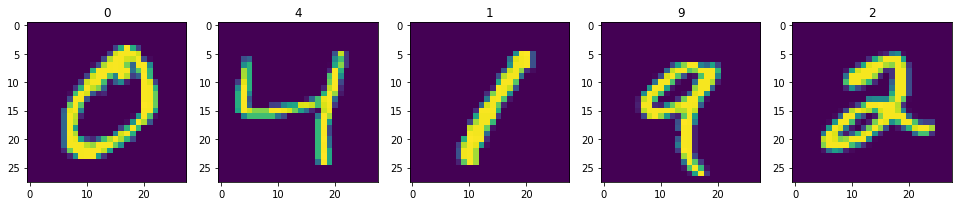

In [ ]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()


In [ ]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./DATA
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Shape of my training samples:

In [ ]:
img, label=mnist_trainset[0]
print(img.shape,label)


torch.Size([1, 28, 28]) 5


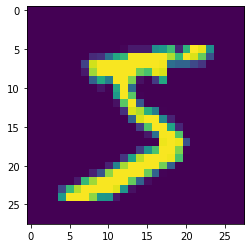

In [ ]:
img = transforms.ToPILImage(mode='L')(img)
plt.imshow(img)

# Multilevel perceptron
Input size = 784 (28 * 28) image size is flattened for 784 pixel values.
The next layer has 120 neurons that are each fed the input array.

After Wx+b, a non linear activation function is applied. The activation function we have used here is ReLu.
ReLU formula is : f(x) = max(0,x)
# ---



The next layer has 84 neurons and takes 120 inputs from the previous layer. The output of this layer is fed into the last layer which is the Output Layer.

The Output Layer has only 10 neurons for the 10 classes that we have(digits between 0-9). For the output layer, we use the softmax function.


Softmax takes the output of the last layer(called logits) which could be any 10 real values and converts it into another 10 real values that sum to 1. Softmax transforms the values between 0 and 1, such that they can be interpreted as probabilities. The maximum value pertains to the class predicted by the classifier.

In [ ]:
class Multilevel_perceptron(nn.Module):
  def __init__(self,input_size = 784,output_size = 10, layers = [120,84]):
    super().__init__()
    self.d1 = nn.Linear(input_size,layers[0])
    self.d2 = nn.Linear(layers[0],layers[1])
    self.d3 = nn.Linear(layers[1],output_size)

  def forward(self,X):
    X = F.relu(self.d1(X))
    X = F.relu(self.d2(X))
    X = self.d3(X)
    return F.log_softmax(X , dim=1)


In [ ]:
model = Multilevel_perceptron()
print(model)

Multilevel_perceptron(
  (d1): Linear(in_features=784, out_features=120, bias=True)
  (d2): Linear(in_features=120, out_features=84, bias=True)
  (d3): Linear(in_features=84, out_features=10, bias=True)
)


# Initializing the loss function and the optimizer

The loss function used here is Cross Entropy Loss.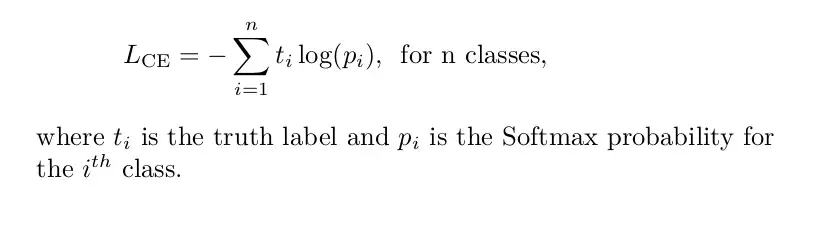

image.png

Adam optimizer is used for the optimizer function

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
for images,labels in train_dataloader:
  print(images.size())
  break
print(images.view(train_batchsize,-1).size())

torch.Size([100, 1, 28, 28])
torch.Size([100, 784])


In [ ]:
for images,labels in test_dataloader:
  print(images.size())
  break
print(images.view(test_batchsize,-1).size())

torch.Size([500, 1, 28, 28])
torch.Size([500, 784])


Initializing the training parameters



In [ ]:
epochs = 10.  # epoch is a single pass through our full training data(60,000 images)
train_size = len(mnist_trainset)/train_batchsize
train_losses = []
test_losses = []
train_correct_list = []
test_correct_list = []

In [ ]:
for i in range(epochs):
  train_correct = 0
  test_correct = 0

  # Run the training batches
  for b, (X_train, y_train) in enumerate(train_dataloader):
    b +=1        # current image
    #Apply the model
    y_pred = model(X_train.view(train_batchsize, -1)) # Here we flatten X_train

    loss = criterion(y_pred, y_train)        # cross entropy loss to calculate the number of correct predictions
    predicted = torch.max(y_pred.data,1)[1]  # the prediction that has the maximum probability
    batch_correct = (predicted == y_train).sum()
    train_correct += batch_correct

    #Update parameters
    optimizer.zero_grad()     # reset the gradients after each training step
    loss.backward()           #to trigger backprop
    optimizer.step()          #perform parameter update

    # Print interim results
    if b % train_size == 0:
      print(f'epoch: {i:2} batch:{b:4} [{train_batchsize*b:6}/len(mnist_trainset)] Train loss: {loss.item():10.8f} Train accuracy: {(train_correct.item()/train_size)}%')


  train_correct_list.append(train_correct)         # Update train Loss & accuracy for the epoch
  train_losses.append(loss)

  # Run the testing batches
  with torch.no_grad(): # don't calculate gradients during testing

    for b,(X_test, y_test) in enumerate(test_dataloader):

      # Apply the model
      y_val = model(X_test.view(test_batchsize, -1)) # Here we flatten X_test

      # Tally the number of correct predictions
      predicted = torch.max(y_val.data, 1)[1]
      test_correct += (predicted == y_test).sum()

    # Update test Loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct_list.append(test_correct)


epoch:  0 batch: 600 [ 60000/60000] Train loss: 0.14159660 Train accuracy: 89.27333333333333%
epoch:  1 batch: 600 [ 60000/60000] Train loss: 0.16910133 Train accuracy: 95.27333333333333%
epoch:  2 batch: 600 [ 60000/60000] Train loss: 0.03161852 Train accuracy: 96.72333333333333%
epoch:  3 batch: 600 [ 60000/60000] Train loss: 0.03844130 Train accuracy: 97.46166666666667%
epoch:  4 batch: 600 [ 60000/60000] Train loss: 0.15490907 Train accuracy: 98.025%
epoch:  5 batch: 600 [ 60000/60000] Train loss: 0.24337988 Train accuracy: 98.40166666666667%
epoch:  6 batch: 600 [ 60000/60000] Train loss: 0.05269320 Train accuracy: 98.60833333333333%
epoch:  7 batch: 600 [ 60000/60000] Train loss: 0.03324822 Train accuracy: 98.92333333333333%
epoch:  8 batch: 600 [ 60000/60000] Train loss: 0.01766952 Train accuracy: 99.12%
epoch:  9 batch: 600 [ 60000/60000] Train loss: 0.04619160 Train accuracy: 99.28166666666667%


In [ ]:
len(test_correct_list)

10

In [ ]:
print(f'Test accuracy:{test_correct_list[-1].item()*100/10000:.3f}%') # test accuracy for the last epoch

Test accuracy:97.730%


In [ ]:
train_losses

[tensor(0.1416, grad_fn=<NllLossBackward0>),
 tensor(0.1691, grad_fn=<NllLossBackward0>),
 tensor(0.0316, grad_fn=<NllLossBackward0>),
 tensor(0.0384, grad_fn=<NllLossBackward0>),
 tensor(0.1549, grad_fn=<NllLossBackward0>),
 tensor(0.2434, grad_fn=<NllLossBackward0>),
 tensor(0.0527, grad_fn=<NllLossBackward0>),
 tensor(0.0332, grad_fn=<NllLossBackward0>),
 tensor(0.0177, grad_fn=<NllLossBackward0>),
 tensor(0.0462, grad_fn=<NllLossBackward0>)]

In [ ]:
train_los = [fl.item() for fl in train_losses]
test_los = [fl.item() for fl in test_losses]

In [ ]:
len(train_los)

10

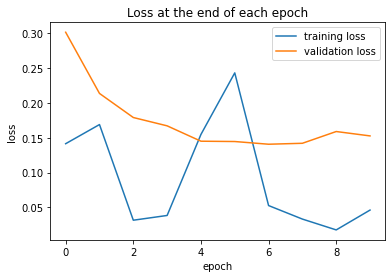

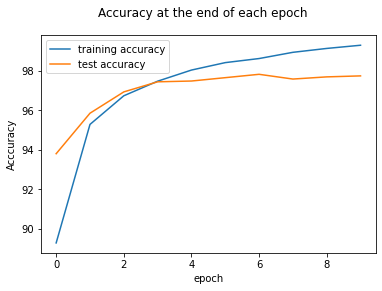

In [ ]:
plt.plot(train_los, label='training loss')
plt.plot(test_los, label='validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

plt.plot([t/600 for t in train_correct_list], label='training accuracy')
plt.plot([t/100 for t in test_correct_list], label='test accuracy')
plt.suptitle('Accuracy at the end of each epoch')
plt.ylabel('Acccuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
